In [1]:
import mesa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
from kaizoji_model.kaizoji_model import KaizojiModel

In [6]:
res = {}
err = {}
wealth = np.arange(1, 1000000, 1000)
count = 0
for f in wealth:
    if count %10 == 0:
        print(count/10, '%')
    for n in wealth:
        try:
            model = KaizojiModel(W_F_ZERO=f, W_N_ZERO=n)
            model.simulate(10)
            if np.mean(model.prices) > 0:
                res[(f,n)] = np.mean(model.prices)
        except ValueError:
            err[(f, n)] = 'err'
    count += 1

print(res)



0.0 %
1.0 %
2.0 %
3.0 %
4.0 %
5.0 %
6.0 %
7.0 %
8.0 %
9.0 %
10.0 %
11.0 %
12.0 %
13.0 %
14.0 %
15.0 %
16.0 %
17.0 %
18.0 %
19.0 %
20.0 %
21.0 %
22.0 %
23.0 %
24.0 %
25.0 %
26.0 %
27.0 %
28.0 %
29.0 %
30.0 %
31.0 %
32.0 %
33.0 %
34.0 %
35.0 %
36.0 %
37.0 %
38.0 %
39.0 %
40.0 %
41.0 %
42.0 %
43.0 %
44.0 %
45.0 %
46.0 %
47.0 %
48.0 %
49.0 %
50.0 %
51.0 %
52.0 %
53.0 %
54.0 %
55.0 %
56.0 %
57.0 %
58.0 %
59.0 %
60.0 %
61.0 %
62.0 %
63.0 %
64.0 %
65.0 %
66.0 %
67.0 %
68.0 %
69.0 %
70.0 %
71.0 %
72.0 %
73.0 %
74.0 %
75.0 %
76.0 %
77.0 %
78.0 %
79.0 %
80.0 %
81.0 %
82.0 %
83.0 %
84.0 %
85.0 %
86.0 %
87.0 %
88.0 %
89.0 %
90.0 %
91.0 %
92.0 %
93.0 %
94.0 %
95.0 %
96.0 %
97.0 %
98.0 %
99.0 %
{(1, 1001): 76.76147433897144, (1, 2001): 39.2257801894097, (1, 3001): 27.52559818696651, (1, 4001): 19.741574589536, (1, 5001): 16.510337152828644, (1, 6001): 16.064969371148397, (1, 7001): 12.250415945125214, (1, 8001): 10.653512957946974, (1, 9001): 9.542884741541213, (1, 10001): 9.933547650397745, (1, 110

In [14]:
temp_res = {}
for key, value in res.items():
    temp_res[value] = key
temp_res

{76.76147433897144: (1, 1001),
 39.2257801894097: (1, 2001),
 27.52559818696651: (1, 3001),
 19.741574589536: (1, 4001),
 16.510337152828644: (1, 5001),
 16.064969371148397: (1, 6001),
 12.250415945125214: (1, 7001),
 10.653512957946974: (1, 8001),
 9.542884741541213: (1, 9001),
 9.933547650397745: (1, 10001),
 9.601189146506302: (1, 11001),
 8.840469999953951: (1, 12001),
 8.191911364248583: (1, 13001),
 7.92243583912026: (1, 14001),
 7.013298883286203: (1, 15001),
 6.242873035223021: (1, 16001),
 6.5469000686504595: (1, 17001),
 5.562941563018334: (1, 18001),
 5.757132442485709: (1, 19001),
 5.664207074348773: (1, 20001),
 7.001026068619233: (1, 21001),
 5.324316882018568: (1, 22001),
 4.205884985230015: (1, 23001),
 5.4462145444017: (1, 24001),
 4.817204605036401: (1, 25001),
 4.7020929407059295: (1, 26001),
 4.120459804981258: (1, 27001),
 4.494322429075026: (1, 28001),
 4.669537058193404: (1, 29001),
 3.859461184469565: (1, 30001),
 4.313155334343676: (1, 31001),
 4.31743520193381

In [15]:
temp_res = dict(sorted(temp_res.items()))
temp_res

{0.9437226471105243: (1, 991001),
 0.9900035579843809: (1, 762001),
 1.001694269773999: (1, 889001),
 1.0122248867557944: (1, 837001),
 1.0135463433998237: (1, 681001),
 1.0344513448901056: (1, 620001),
 1.0482921599264108: (1, 863001),
 1.0486158247602528: (1, 864001),
 1.0554747601202004: (1, 831001),
 1.0593524684303341: (1, 663001),
 1.075590029473539: (1, 616001),
 1.0790622192080068: (1, 929001),
 1.0809611755817252: (1, 914001),
 1.0847331627329575: (1, 714001),
 1.1072430060640341: (1, 644001),
 1.1167619046184332: (1, 752001),
 1.117487411617141: (1, 961001),
 1.118213022337551: (1, 747001),
 1.1249530829846779: (1, 722001),
 1.130015239511299: (1, 705001),
 1.143466789351439: (1, 473001),
 1.1531777074243066: (1, 632001),
 1.1552758020516856: (1, 627001),
 1.1554564488924548: (1, 772001),
 1.166164830179303: (1, 599001),
 1.1667082951838978: (1, 939001),
 1.166821592849779: (1, 597001),
 1.1671427138859345: (1, 596001),
 1.1676277504966825: (1, 384001),
 1.1701675482104952: (

In [20]:
new_model = KaizojiModel(W_F_ZERO=1001, W_N_ZERO=995001)
new_model.simulate()
new_model.get_variables()['prices']

[1,
 88.55168815968352,
 88.48063391761332,
 88.42369813099481,
 88.33832554662602,
 88.26192912780759,
 88.20235032458065,
 88.1475999226954,
 88.08926892425349,
 88.0260339618901,
 88.02902539525668,
 88.039818072465,
 87.99468811420608,
 87.92373345409032,
 87.95654519250691,
 87.92285458865481,
 87.91248165891632,
 87.90894819128599,
 87.87547061416674,
 87.8670652965359,
 87.87660515786409,
 87.83214175656403,
 87.7986515036354,
 87.77133780836488,
 87.77275978210382,
 87.75806715431374,
 87.71638002767942,
 87.6962353703977,
 87.65450790821583,
 87.62945441880238,
 87.59989738482712,
 87.56236862319473,
 87.55314666154158,
 87.51619239162648,
 87.47903106092376,
 87.46366868420648,
 87.42040886555125,
 87.38684046534708,
 87.36718681570878,
 87.33377689838845,
 87.30678093133253,
 87.25788780954421,
 87.22089611327463,
 87.16291714853519,
 87.15443147978925,
 87.11719412510568,
 87.08339697070564,
 87.0644520028536,
 87.03423971090487,
 87.00712969793287,
 86.96722387934277,
 86.

In [21]:
varss = new_model.get_variables()

min_len = 1E100
for value in varss.values():
    min_len = min(min_len, len(value))

for key in varss:
    while len(varss[key]) != min_len:
        varss[key].pop()

df = pd.DataFrame(varss)
df.head()

,dividends,fractions_risky_n,prices,wealth_f,wealth_n,fractions_risky_f,momentums,couplings,p_free_to_risk_n,p_risk_to_free_n
0,0.040000,0.30,1.000000,1001.000000,9.950010e+05,0.300000,0.040000,0.196000,0.200000,0.200000
1,0.040035,0.38,88.551688,27304.850468,2.714121e+07,591.310210,4.415584,0.195104,0.181467,0.018533
2,0.040055,0.53,88.480634,20363.303107,2.713895e+07,591.968012,4.194765,0.197440,0.184006,0.015994
3,0.040089,0.60,88.423698,17105.419199,2.713723e+07,592.719538,3.984995,0.197420,0.182620,0.017380
4,0.040109,0.73,88.338326,11105.761974,2.712976e+07,593.459270,3.785697,0.196442,0.183403,0.016597


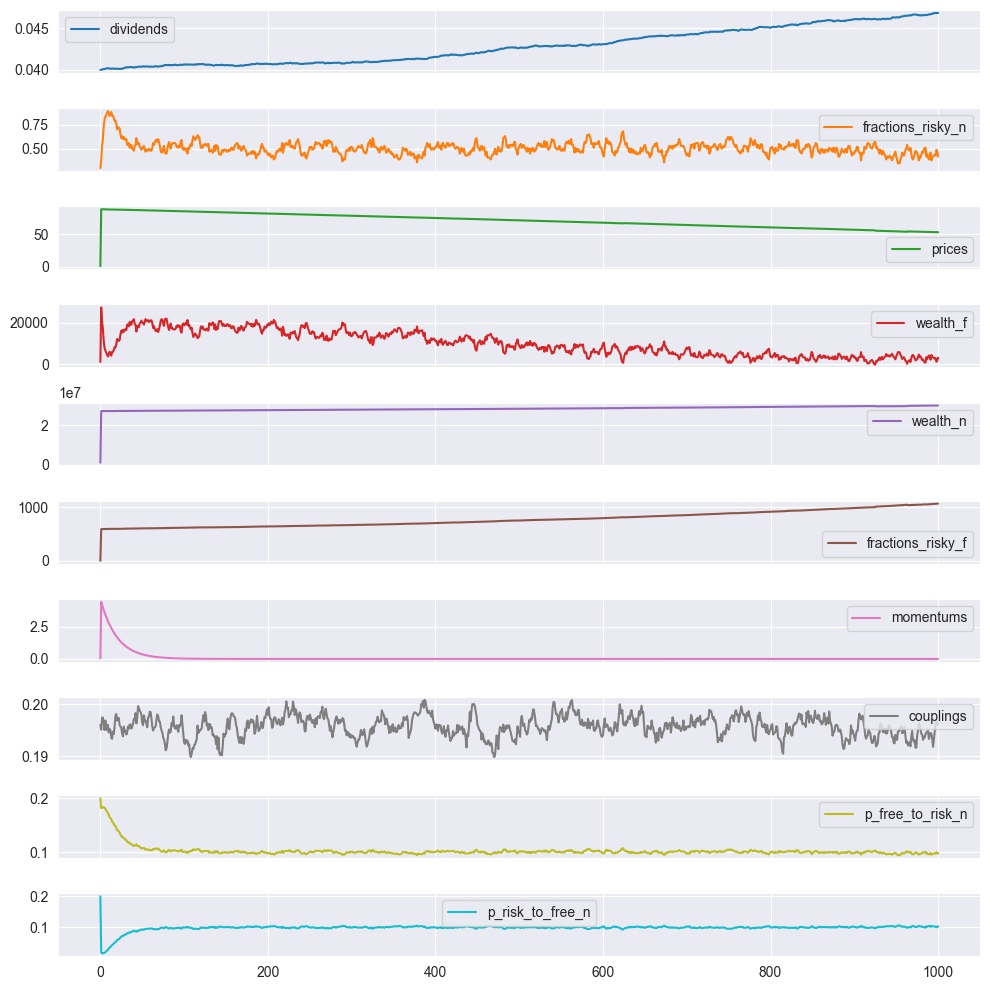

In [22]:
df.plot(subplots=True, figsize = [10,10])

plt.tight_layout()
plt.show();

In [ ]:
vars = model.get_variables()
vars['p_risk_to_free_n']